<a href="https://colab.research.google.com/github/MarkVoitov/artificial_intelligence_course/blob/main/agroinsurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Описание предметной области**

Для анализа используются данные с комических фотоспутников Sentinel - 2A, 2B. Эти спутники Европейского космического агентства Sentinel оснащены оптико-электронным мультиспектральным сенсором для съемок с разрешением от 10 до 60 м в видимой, ближней инфракрасной (VNIR) и коротковолновой инфракрасной (SWIR) зонах спектра, включающих в себя 13 спектральных каналов. Значения этих каналов являются входящими данными для последующего анализа.

Одним из основных инструментов для оценки состояния и роста растений, включая сельскохозяйственные, являются различные вегетационные индексы. Самый популярный – индекс NDVI. NDVI (Normalized difference vegetation index, Нормализованный вегетационный индекс) — это показатель здоровья растения, который вычисляется по тому, как растение отражает и поглощает разные световые волны.

Расчет NDVI базируется на двух наиболее стабильных участках спектральной кривой отражения сосудистых растений. В красной области спектра (0,6-0,7 мкм) лежит максимум поглощения солнечной радиации хлорофиллом высших сосудистых растений, а в инфракрасной области (0,7-1,0 мкм) находится область максимального отражения клеточных структур листа. То есть высокая фотосинтетическая активность (связанная, как правило, с густой растительностью) ведет к меньшему отражению в красной области спектра и большему в инфракрасной. Отношение этих показателей друг к другу позволяет четко отделять и анализировать растительные от прочих природных объектов. Для спутников Sentinel-2 индекс NDVI рассчитывается на основе значений спектральных каналов B8A и B04 по формуле: (B8A-B04)/(B8A+B04). Согласно этой формуле, плотность растительности в определенной точке изображения равна разнице интенсивностей отраженного света в красном и инфракрасном диапазоне, деленной на сумму их интенсивностей. NDVI принимает значение от -1 до 1. Для здоровых растений индекс, как правило, принимает значение от 0,2 до 0,9.

При отрицательных и близких к нулю значениях индекса можно смело предположить, что перед нами не растение. Если на снимке присутствует облачность, индекс стремится к 0, поэтому очень важно использовать для анализа спутниковые данные, очищенные от облачности. В рамках кейса посмотрите, как изменяется NDVI по времени, обратите внимание на зависимость сезонов и значений индекса до фильтрации облачности и после.

**Структура данных**

Файл nti_case_clouds.csv – исходные данные:

• subpoint_id – координаты точки;

• date – дата получения значений каналов;

• is_cloud_free – булевые значения облачности;

• B1-B12 – спектральные значения каналов;

• NDVI – вегетационный индекс.

***1. Подготовка данных***

*a. Откройте данные и изучите их.*

In [1]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 29 kB/s 


In [2]:
# импорты
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from sklearn.metrics import mean_absolute_error, f1_score, classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [3]:
# чтение данных
data = pd.read_csv('/content/drive/MyDrive/Colab_notebooks/artificial_intelligence_course/01_agroinsurance/nti_case_clouds.csv')
data.head()

,subpoint_id,date,is_cloud_free,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12,NDVI
0,SF1P1-1,2019-03-11,False,0.5138,0.4963,0.4455,0.4924,0.4932,0.5166,0.5393,0.5107,0.5479,0.2708,0.0092,0.3891,0.3258,0.053350
1,SF1P1-1,2019-02-27,False,0.4489,0.4213,0.3800,0.3995,0.4100,0.4299,0.4341,0.4245,0.4440,0.3081,0.1443,0.2508,0.2551,0.052756
2,SF1P1-1,2019-02-14,False,0.5557,0.5389,0.4700,0.5047,0.5160,0.5273,0.5406,0.5256,0.5408,0.2433,0.0041,0.4014,0.3189,0.034529
3,SF1P1-1,2019-02-02,False,0.6908,0.6897,0.6244,0.7206,0.7285,0.7430,0.7597,0.7388,0.7718,0.2515,0.0033,0.5589,0.3885,0.034307
4,SF1P1-1,2019-01-20,False,0.4461,0.4143,0.3245,0.3428,0.3553,0.3788,0.3903,0.3674,0.3918,0.1909,0.0239,0.2154,0.1887,0.066703


In [4]:
# размерность датасета (n_samples, n_features)
data.shape

(2100, 17)

In [5]:
# общая информация о наполнении датасета
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subpoint_id    2100 non-null   object 
 1   date           2100 non-null   object 
 2   is_cloud_free  2100 non-null   bool   
 3   B01            2100 non-null   float64
 4   B02            2100 non-null   float64
 5   B03            2100 non-null   float64
 6   B04            2100 non-null   float64
 7   B05            2100 non-null   float64
 8   B06            2100 non-null   float64
 9   B07            2100 non-null   float64
 10  B08            2100 non-null   float64
 11  B8A            2100 non-null   float64
 12  B09            2100 non-null   float64
 13  B10            2100 non-null   float64
 14  B11            2100 non-null   float64
 15  B12            2100 non-null   float64
 16  NDVI           2100 non-null   float64
dtypes: bool(1), float64(14), object(2)
memory usage: 264

In [6]:
# описательная статистика количественных признаков (13 спектральных каналов и индекс NDVI)
data.describe()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12,NDVI
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,0.447812,0.425303,0.383486,0.406532,0.423668,0.462974,0.485719,0.468045,0.499315,0.222634,0.027609,0.283055,0.223174,0.170749
std,0.244932,0.251303,0.231734,0.261119,0.255174,0.234796,0.232699,0.223713,0.229056,0.140130,0.041263,0.143085,0.119401,0.211491
min,0.100500,0.072100,0.060200,0.032900,0.039500,0.037200,0.035800,0.035800,0.032400,0.014800,0.000700,0.011600,0.007000,-0.208975
25%,0.172075,0.143450,0.131775,0.134925,0.156775,0.249500,0.283000,0.274950,0.304675,0.101400,0.002700,0.181975,0.133050,0.032348
50%,0.492200,0.470000,0.415550,0.432250,0.436600,0.468800,0.489700,0.466000,0.499350,0.199100,0.008800,0.253100,0.210300,0.061664
75%,0.657825,0.643800,0.575900,0.632800,0.648075,0.664100,0.681325,0.656000,0.691100,0.317725,0.034600,0.367450,0.294850,0.250435
max,1.047200,1.047600,1.031300,1.168900,1.146400,1.164600,1.189600,1.178800,1.213900,0.779100,0.343500,0.970400,0.851500,0.865218


In [7]:
# возможно, столбец 'is_cloud_free' с булевым типом данных в дальнейшем будет являться таргетом (меткой класса), можно сразу посмотреть распределение значений признака
data['is_cloud_free'].value_counts()

False    1621
True      479
Name: is_cloud_free, dtype: int64

Около 22% снимков - безоблачные.

*b. Посмотрите на названия столбцов и приведите их к нижнему регистру.*

In [8]:
data.columns

Index(['subpoint_id', 'date', 'is_cloud_free', 'B01', 'B02', 'B03', 'B04',
       'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12', 'NDVI'],
      dtype='object')

In [9]:
data.columns = data.columns.str.lower()
data.columns

Index(['subpoint_id', 'date', 'is_cloud_free', 'b01', 'b02', 'b03', 'b04',
       'b05', 'b06', 'b07', 'b08', 'b8a', 'b09', 'b10', 'b11', 'b12', 'ndvi'],
      dtype='object')

*c. Проведите предобработку данных.*

С типами данных всё в порядке: айди записи и дата в строковом формате, остальные значения кроме метки класса - в формате float64. Поэтому типы данных не меняем. Замена значения столбца с облачностью - в следующем задании d.

In [10]:
# посмотрим количество пропусков в столбцах
data.isna().sum()

subpoint_id      0
date             0
is_cloud_free    0
b01              0
b02              0
b03              0
b04              0
b05              0
b06              0
b07              0
b08              0
b8a              0
b09              0
b10              0
b11              0
b12              0
ndvi             0
dtype: int64

In [11]:
# проверим наличие дубликатов
data.duplicated().sum()

55

Изначально здесь  в качестве предобработки данных я удалял дубликаты:
data = data.drop_duplicates().reset_index(drop=True),
но в дальнейшем из-за несбалансированности классов был применён метод upsampling, выполняющий, по сути, обратную удалению дубликатов операцию - для баланса классов были добавлены копии строк меньшего класса. Поэтому, возвращаясь сюда, логичнее от drop_duplicates() тоже отказаться.

*d. Замените булевые значения столбца с облачностью на «int» (True – 1/False – 0)*.

In [12]:
data['is_cloud_free'] = data['is_cloud_free'].replace({True: 1, False:0})

*e. Проверьте, что индекс NDVI получен верный. Рассчитайте значение индекса NDVI по формуле (b8a-b04)/(b8a+b04) и сравните с искомым (найдите МАЕ между вашими расчетами и значениями индекса).*

In [13]:
# добавим столбец ndvi_calculated с расчётным значением индекса
data['ndvi_calculated'] = (data['b8a'] - data['b04']) / (data['b8a'] + data['b04'])

# добавим ещё один столбец со значениями mean_absolute_error между искомыми и расчётными значениями индекса
data['ndvi_mae'] = mean_absolute_error(data['ndvi'], data['ndvi_calculated'])

data.head()

,subpoint_id,date,is_cloud_free,b01,b02,b03,b04,b05,b06,b07,b08,b8a,b09,b10,b11,b12,ndvi,ndvi_calculated,ndvi_mae
0,SF1P1-1,2019-03-11,0,0.5138,0.4963,0.4455,0.4924,0.4932,0.5166,0.5393,0.5107,0.5479,0.2708,0.0092,0.3891,0.3258,0.053350,0.053350,2.555470e-09
1,SF1P1-1,2019-02-27,0,0.4489,0.4213,0.3800,0.3995,0.4100,0.4299,0.4341,0.4245,0.4440,0.3081,0.1443,0.2508,0.2551,0.052756,0.052756,2.555470e-09
2,SF1P1-1,2019-02-14,0,0.5557,0.5389,0.4700,0.5047,0.5160,0.5273,0.5406,0.5256,0.5408,0.2433,0.0041,0.4014,0.3189,0.034529,0.034529,2.555470e-09
3,SF1P1-1,2019-02-02,0,0.6908,0.6897,0.6244,0.7206,0.7285,0.7430,0.7597,0.7388,0.7718,0.2515,0.0033,0.5589,0.3885,0.034307,0.034307,2.555470e-09
4,SF1P1-1,2019-01-20,0,0.4461,0.4143,0.3245,0.3428,0.3553,0.3788,0.3903,0.3674,0.3918,0.1909,0.0239,0.2154,0.1887,0.066703,0.066703,2.555470e-09


In [14]:
print('Уникальные значения MAE для NDVI:', data['ndvi_mae'].unique())

Уникальные значения MAE для NDVI: [2.5554701e-09]


Средняя абсолютная ошибка для всех записей составила 2.55480362e-09. Очень малое значение, отличное от нуля, хотя это и не ноль.

***2. Анализ данных***

*a. Посмотрите, как изменяется индекс NDVI для точки Sr_205_1 по времени.*

In [15]:
# для анализа данных по точке Sr_205_1 отфильтруем в новую таблицу записи с искомым subpoint_id,
# уберём лишние столбцы со спектральными каналами,
# для удобства построения графиков приведём дату к формату datetime64
data_sr_205_1 = data[data['subpoint_id'] == 'Sr_205_1'][['date', 'ndvi', 'is_cloud_free']].sort_values(by=['date']).reset_index(drop=True)
data_sr_205_1['date']= pd.to_datetime(data_sr_205_1['date'], format='%Y.%m.%d')
data_sr_205_1

,date,ndvi,is_cloud_free
0,2019-01-02,0.045670,0
1,2019-01-02,0.045670,0
2,2019-01-07,0.023028,0
3,2019-01-10,0.059419,0
4,2019-01-12,0.033520,0
...,...,...,...
201,2019-12-21,0.082549,0
202,2019-12-23,-0.019091,0
203,2019-12-23,-0.019088,0
204,2019-12-26,0.061361,0


Видим, что для точки Sr_205_1 значения индекса NDVI распределены в течение 2019г.

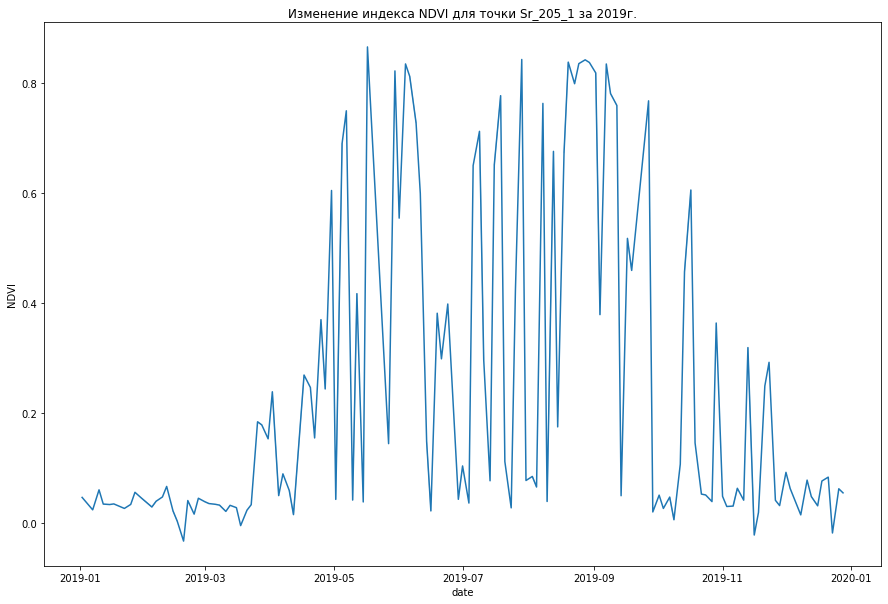

In [16]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=data_sr_205_1, x='date', y='ndvi')
plt.ylabel('NDVI')
plt.title('Изменение индекса NDVI для точки Sr_205_1 за 2019г.')
plt.show()

На графике видно, что значения индекса могут довольно сильно изменяться в течение одного месяца.

*b. Постройте графики NDVI для точки Sr_205_ отдельно для безоблачных снимков и всех снимков (поле is_cloud_free).*

Обратите внимание на поведение индекса. Сделайте вывод.

График NDVI для точки Sr_205_1 для всех снимков уже отображён выше.

Посмотрим распределение значений по столбцу is_cloud_free.


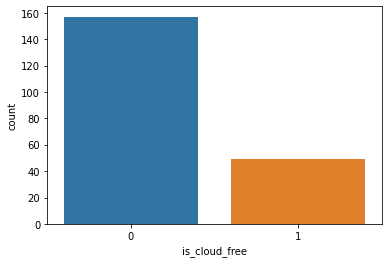

In [17]:
sns.countplot(data_sr_205_1['is_cloud_free'])
plt.show()

In [18]:
data_sr_205_1['is_cloud_free'].value_counts()

0    157
1     49
Name: is_cloud_free, dtype: int64

Почти 24% снимков для точки Sr_205_1 - безоблачные.

Построим аналогичный график только для безоблачных снимков.

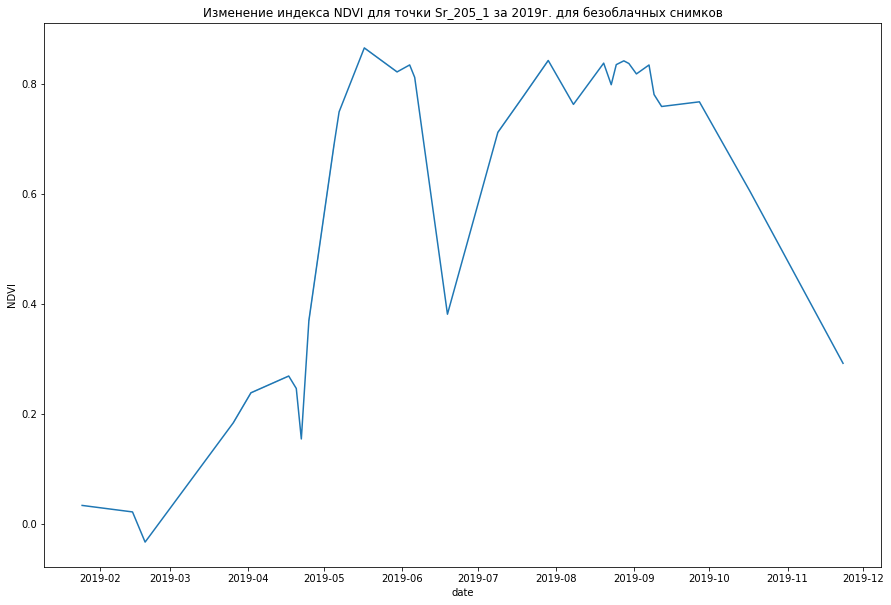

In [19]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=data_sr_205_1[data_sr_205_1['is_cloud_free'] == 1], x='date', y='ndvi')
plt.ylabel('NDVI')
plt.title('Изменение индекса NDVI для точки Sr_205_1 за 2019г. для безоблачных снимков')
plt.show()

Как мы помним из описания предметной области, для здоровых растений индекс NDVI, как правило, принимает значение от 0,2 до 0,9. В тоже время при отрицательных и близких к нулю значениях индекса рекомендовано предполагать, что перед нами не растение. При наличии облачности на снимке индекс стремится к нулю.

Таким образом, мы видим, что на общем графике для всех снимков такой разброс значений обусловлен облачностью. В тоже время значения индекса для всех снимков лежат около нуля в начале и в конце года - как мы помним, в холодное время года с конца осени по начало весны в европейской части Земли небо, как правило, больше затянуто облаками, что обеспечивает преимущественно околонулевые значения индекса в начале и в конце графика. Данный вывод корректен при допущении, что спутники Европейского космического агентства делают снимки на территории Европы.

***3. Постройте модель определения облачности***

*a. Удалите столбцы перед обучение модели ('subpoint_id', 'date', рассчитанный NDVI)*

In [20]:
data = data.drop(['subpoint_id', 'date', 'ndvi_calculated',	'ndvi_mae'], axis=1)
data.head()

,is_cloud_free,b01,b02,b03,b04,b05,b06,b07,b08,b8a,b09,b10,b11,b12,ndvi
0,0,0.5138,0.4963,0.4455,0.4924,0.4932,0.5166,0.5393,0.5107,0.5479,0.2708,0.0092,0.3891,0.3258,0.053350
1,0,0.4489,0.4213,0.3800,0.3995,0.4100,0.4299,0.4341,0.4245,0.4440,0.3081,0.1443,0.2508,0.2551,0.052756
2,0,0.5557,0.5389,0.4700,0.5047,0.5160,0.5273,0.5406,0.5256,0.5408,0.2433,0.0041,0.4014,0.3189,0.034529
3,0,0.6908,0.6897,0.6244,0.7206,0.7285,0.7430,0.7597,0.7388,0.7718,0.2515,0.0033,0.5589,0.3885,0.034307
4,0,0.4461,0.4143,0.3245,0.3428,0.3553,0.3788,0.3903,0.3674,0.3918,0.1909,0.0239,0.2154,0.1887,0.066703


*b. Разбейте выборку на 2 – train, valid в соотношении 75/25.*

In [21]:
X_train, x_valid, y_train, y_valid = train_test_split(data.iloc[:, 1:], data['is_cloud_free'], train_size=0.75, stratify=data['is_cloud_free'])

*c. Посмотрите, сбалансированы ли данные на всей выборке; в случае дисбаланса используйте технику upsample для создания сбалансированной выборки, далее используйте её в качестве обучающей.*

Ранее уже было отмечено, что количество безоблачных снимков намного меньше, т.е. данные не сбалансированы, смещение в сторону снимков с облаками (data['is_cloud_free'] == 1)

In [22]:
# ещё раз посмотрим распределение меток классов в таблицe data
data['is_cloud_free'].value_counts()

0    1621
1     479
Name: is_cloud_free, dtype: int64

In [23]:
# посмотрим соотношение - во сколько раз нулей больше, чем единиц
is_cloud_free_values_ratio = round(len(data[data['is_cloud_free'] == 0]) / len(data[data['is_cloud_free'] == 1]), 1)
is_cloud_free_values_ratio

3.4

Поскольку классы в выборке не сбалансированы, использованное выше разбиение датасета на части для обучения и валидации не совсем корректно.

Используем upsampling. Для этого нужно добавить в датасет записей со значением data['is_cloud_free'] == 1 в количестве is_cloud_free_values_ratio == 3.4 раз.

In [24]:
data_is_cloud_free = data[data['is_cloud_free'] == 1]
data_is_cloud_free = data_is_cloud_free.loc[data_is_cloud_free.index.repeat(is_cloud_free_values_ratio)]
data = pd.concat([data[data['is_cloud_free']==0], data_is_cloud_free]).reset_index(drop=True)

In [25]:
# снова посмотрим распределение меток классов в таблицe data
data['is_cloud_free'].value_counts()

0    1621
1    1437
Name: is_cloud_free, dtype: int64

Распределение отличается, т.к. ранее значение is_cloud_free_values_ratio было округлено. В целом, теперь, после применения техники upsample, выборку можно считать сбалансированной.

In [26]:
# повторим разбиение на обучающую и валидационную выборки
X_train, x_valid, y_train, y_valid = train_test_split(data.iloc[:, 1:], data['is_cloud_free'], train_size=0.75, stratify=data['is_cloud_free'])

*d. Обучите различные модели на обучающей сбалансированной выборке и найдите F1_score для валидационной выборки.*

Попробуем применить основные классические алгоритмы машинного обучения с гиперпараметрами по умолчанию.

**1) K-Nearest Neighbors (KNN)**

In [27]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
predicted_knn = model_knn.predict(x_valid)
f1_score(y_valid, predicted_knn)

0.935483870967742

**2) Logistic regression**

In [28]:
model_log_reg = LogisticRegression()
model_log_reg.fit(X_train, y_train)
predicted_log_reg = model_log_reg.predict(x_valid)
f1_score(y_valid, predicted_log_reg)

0.8526315789473684

**3) Naive Bayes**

In [29]:
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)
predicted_nb = model_nb.predict(x_valid)
f1_score(y_valid, predicted_nb)

0.8437917222963953

**4) Decision Tree**

In [30]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
predicted_dt = model_dt.predict(x_valid)
f1_score(y_valid, predicted_dt)

0.9876203576341127

**5) Support Vector Machines (SVM)**

In [31]:
model_svm = SVC()
model_svm.fit(X_train, y_train)
predicted_svm = model_svm.predict(x_valid)
f1_score(y_valid, predicted_svm)

0.9161118508655125

**6) Random Forest**

In [32]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
predicted_rf = model_rf.predict(x_valid)
f1_score(y_valid, predicted_rf)

0.9930843706777317

**7) XGBoost**

In [33]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
predicted_xgb = model_xgb.predict(x_valid)
f1_score(y_valid, predicted_xgb)

0.9779614325068869

**8) CatBoost**

In [34]:
model_cat = CatBoostClassifier()
model_cat.fit(X_train, y_train, verbose=200)
predicted_cat = model_cat.predict(x_valid)
f1_score(y_valid, predicted_cat)

Learning rate set to 0.014683
0:	learn: 0.6662547	total: 54.7ms	remaining: 54.6s
200:	learn: 0.0824873	total: 1.04s	remaining: 4.13s
400:	learn: 0.0489085	total: 2.02s	remaining: 3.02s
600:	learn: 0.0326153	total: 3s	remaining: 1.99s
800:	learn: 0.0225984	total: 3.96s	remaining: 984ms
999:	learn: 0.0167841	total: 4.92s	remaining: 0us


0.9944598337950139

Очевидно, что наилучшие результаты без углубления в подбор гиперпараметров показывают так называемые "деревянные" алгоритмы, т.е. модели, в основе которых лежат деревья решений.
Далее попробуем улучшить результат, работая с четырьмя моделями с наивысшим значением метрики F1 score:
- XGBoost (F1 score = 0.9779);
- Decision Tree (F1 score = 0.9876);
- Random Forest (F1 score = 0.9930);
- CatBoost (F1 score = 0.9944).

*e. Выберите лучшую модель и гиперпараметры, проверьте ваш результат.*

Для подбора гиперпараметров воспользуемся GridSearchCV.

**1) XGBoost**

In [35]:
# задаём словарь из возможных значений гиперпараметров и запускаем поиск лучших значений
params_grid_xgb = {'max_depth': np.arange(6),
                   'n_estimators': [100, 200],
                   'min_child_weight': [1, 5, 10],
                   'gamma': [0.5, 1, 1.5, 2, 5]}

grid_xgb = GridSearchCV(XGBClassifier(), params_grid_xgb)
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'gamma': [0.5, 1, 1.5, 2, 5],
                         'max_depth': array([0, 1, 2, 3, 4, 5]),
                         'min_child_weight': [1, 5, 10

In [36]:
grid_xgb.best_params_

{'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}

In [37]:
# запустим классификатор с наилучшими гиперпараметрами
model_xgb_best_params = XGBClassifier(gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=200)
model_xgb_best_params.fit(X_train, y_train)
predicted_xgb_best_params = model_xgb_best_params.predict(x_valid)
f1_score(y_valid, predicted_xgb_best_params)

0.9903448275862068

В результате применения GridSearchCV метрика F1 score улучшилась с 0.9779 до 0.9903.

**2) Decision Tree**

In [38]:
# задаём словарь из возможных значений гиперпараметров и запускаем поиск лучших значений
params_grid_dt = {'criterion': ['gini', 'entropy'],
                  'min_samples_split': [2, 3, 4],
                  'max_depth': [2, 6, 8, 10]}

grid_dt = GridSearchCV(DecisionTreeClassifier(), params_grid_dt)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                

In [39]:
grid_dt.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 3}

In [40]:
# запустим классификатор с наилучшими гиперпараметрами
model_dt_best_params = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=3)
model_dt_best_params.fit(X_train, y_train)
predicted_dt_best_params = model_dt_best_params.predict(x_valid)
f1_score(y_valid, predicted_dt_best_params)

0.9821182943603851

В результате применения GridSearchCV метрика F1 score ухудшилась с 0.9876 до 0.9821.

**3) Random Forest**

In [41]:
# задаём словарь из возможных значений гиперпараметров и запускаем поиск лучших значений
params_grid_rf = {'max_depth': np.arange(6),
                  'n_estimators': [200, 500, 1000],
                  'max_features': ['auto', 'sqrt', 'log2']}

grid_rf = GridSearchCV(RandomForestClassifier(), params_grid_rf)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [42]:
grid_rf.best_params_

{'max_depth': 5, 'max_features': 'log2', 'n_estimators': 1000}

In [43]:
# запустим классификатор с наилучшими гиперпараметрами
model_rf_best_params = RandomForestClassifier(max_depth=5, max_features='log2', n_estimators=1000)
model_rf_best_params.fit(X_train, y_train)
predicted_rf_best_params = model_rf_best_params.predict(x_valid)
f1_score(y_valid, predicted_rf_best_params)

0.957004160887656

В результате применения GridSearchCV метрика F1 score ухудшилась с 0.9930 до 0.9570.

**4) CatBoost**

In [44]:
# задаём словарь из возможных значений гиперпараметров и запускаем поиск лучших значений
params_grid_cat = {'depth': [4, 6, 10],
                   'loss_function': ['Logloss', 'CrossEntropy'],
                   'iterations' : [10, 50, 100]}

grid_cat = GridSearchCV(CatBoostClassifier(), params_grid_cat)
grid_cat.fit(X_train, y_train, verbose=False)

GridSearchCV(cv=None, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fb20ffa8c10>,
             iid='deprecated', n_jobs=None,
             param_grid={'depth': [4, 6, 10], 'iterations': [10, 50, 100],
                         'loss_function': ['Logloss', 'CrossEntropy']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [45]:
grid_cat.best_params_

{'depth': 10, 'iterations': 100, 'loss_function': 'Logloss'}

In [46]:
# запустим классификатор с наилучшими гиперпараметрами
model_cat_best_params = CatBoostClassifier(depth=10, iterations=100, loss_function='Logloss')
model_cat_best_params.fit(X_train, y_train, verbose=25, plot=True)
predicted_cat_best_params = model_cat_best_params.predict(x_valid)
f1_score(y_valid, predicted_cat_best_params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.12129
0:	learn: 0.6112045	total: 35.8ms	remaining: 3.54s
25:	learn: 0.1338633	total: 917ms	remaining: 2.61s
50:	learn: 0.0803855	total: 1.79s	remaining: 1.72s
75:	learn: 0.0609696	total: 2.68s	remaining: 846ms
99:	learn: 0.0485892	total: 3.53s	remaining: 0us


0.9737931034482757

В результате применения GridSearchCV метрика F1 score ухудшилась с 0.9944 до 0.9737.

*i. Модель должна предсказывать, есть ли облачность на валидационной выборке. Для успешного прохождения необходимо достигнуть F1_score > 0.9.*

In [48]:
print('Лучший классификатор - CatBoost, F1 score =', f1_score(y_valid, predicted_cat))

Лучший классификатор - CatBoost, F1 score = 0.9944598337950139


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       406
           1       0.99      1.00      0.99       359

    accuracy                           0.99       765
   macro avg       0.99      1.00      0.99       765
weighted avg       0.99      0.99      0.99       765



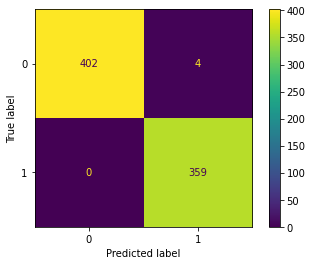

In [50]:
# посмотрим основные метрики классификатора и матрицу ошибок
print(classification_report(y_valid, predicted_cat))
plot_confusion_matrix(model_cat, x_valid, y_valid, values_format='d')
plt.show()

*f. Результаты предсказаний необходимо проверить на тестовой выборке (импортируйте тестовую выборку , обратите внимание на поля, они должны быть идентичными, как в очищенной исходной выборке).*

Тестовая выборка была удалена из постановки задачи. Результирующей метрикой считаем F1 score на валидационной выборке.